# Trilateration: Analysis

Given a set of RTT samples annotated by probe and anchor ID, and metadata about anchors including location, explore how good the data set is for trilateration. (It isn't). This is kind of a scrapyard of ideas for taking this work further; you really should be reading [the paper](paper.ipynb) instead.

### Needful things

First, imports, utility functions, etc. required for analysis, and thaw out the datastore

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

from collections import namedtuple

import warnings
warnings.filterwarnings("ignore") 

In [2]:
with pd.HDFStore('rtt.h5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    rtt_df = store['rtt_df']

### Analysis dataframe preparation

Load the raw RTT dataframe from dataprep, then alculate minumum RTT per anchor/probe pair, and join anchor and probe location to this dataframe.


In [3]:
min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min()})
loc_by_aid = anchor_df.loc[:,('lon','lat')]
loc_by_aid.columns = ['alon','alat']
loc_by_pid = probe_df.loc[:,('lon','lat')]
loc_by_pid.columns = ['plon','plat']
min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

Now calculate distance with a vectorization of the unit sphere distance algorithm.

In [4]:
min_df['tmp_aphi'] = (90.0 - min_df['alat']) * math.pi/180.0
min_df['tmp_pphi'] = (90.0 - min_df['plat']) * math.pi/180.0
min_df['tmp_atheta'] = min_df['alon'] * math.pi/180.0
min_df['tmp_ptheta'] = min_df['plon'] * math.pi/180.0
min_df['tmp_cos'] = ( np.sin(min_df['tmp_aphi']) * np.sin(min_df['tmp_pphi']) * 
                      np.cos(min_df['tmp_atheta'] - min_df['tmp_ptheta']) + 
                      np.cos(min_df['tmp_aphi']) * np.cos(min_df['tmp_pphi']) )
min_df['km'] = np.arccos(min_df['tmp_cos']) * 6371
del min_df['tmp_aphi']
del min_df['tmp_pphi']
del min_df['tmp_atheta']
del min_df['tmp_ptheta']
del min_df['tmp_cos']

### Basic exploration of the dataset

Plot of our RTT samples by minimum RTT and distance, along with a linear fit.

In [5]:
def plot_linfit_rtt_by_dist(plot_df, use_log=True, figsize=(12,8), label="all anchors"):

    plt.figure(figsize=figsize)
    x = plot_df['km']
    y = plot_df['minrtt'] / 2
    if use_log:
        plt.hexbin(x, y, cmap="Greys", bins="log")
    else:
        plt.hexbin(x, y, cmap="Greys")
    plt.colorbar()
    plt.xlabel("distance (km)")
    plt.ylabel("rtt (µs)")
    plt.ylim(0,300000)
    plt.title("Linear fit RTT by distance for {}".format(label))

    (slope, intercept, r, p, e) = scipy.stats.linregress(plot_df['km'],plot_df['minrtt']/2)
    plt.plot(x, slope * x + intercept)
    
    return (slope, r)


8.92915106269
0.877830805647


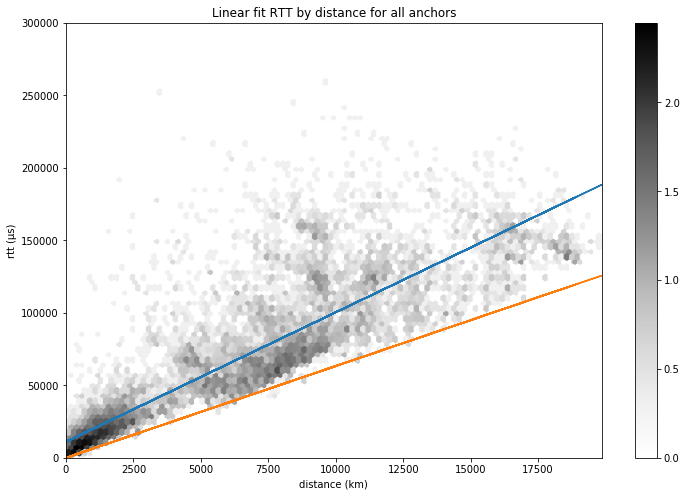

In [6]:
(slope, rval) = plot_linfit_rtt_by_dist(min_df)
print(slope)
print(rval)
plt.plot(min_df['km'], 6.33 * min_df['km'])

This is a better R-value than we'd expect, actually. 

Let's derive an Internet Lightspeed Factor (ILF) from the slope of the line over which all (almost all) samples remain. 

In [7]:
c = 299792458
ilf = (1e9 / 6.33) / c
slf = (1e9 / slope) / c
slf

0.37356753498314321

Is the correlation dependent on RTT or anchor? First, RTT bins:

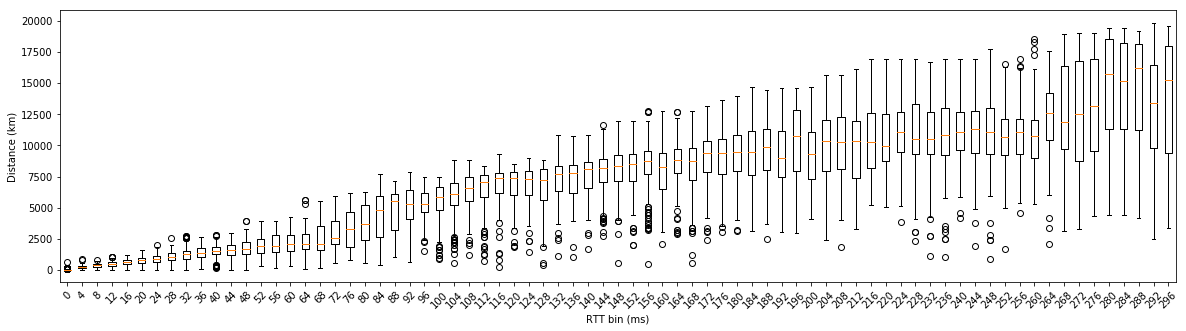

In [8]:
BINSKIP = 4000
BINMAX = 300000

rtt_bin = [0, BINSKIP]
km_sets = []

while rtt_bin[1] <= BINMAX:
    sub_df = min_df[(min_df['minrtt'] >= rtt_bin[0]) & (min_df['minrtt'] < rtt_bin[1])]
    # (m, b, r, p, e) = scipy.stats.linregress(sub_df['km'],sub_df['minrtt']/2)
    # print ("Between {} and {} µs, slope is {}, rvalue is {}".format(rtt_bin[0], rtt_bin[1], m, r))
    km_sets.append(sub_df['km'])
    rtt_bin[0] += BINSKIP
    rtt_bin[1] += BINSKIP

plt.figure(figsize=(20,5))
plt.boxplot(km_sets)
plt.xlabel("RTT bin (ms)")
plt.xticks(np.arange(1,BINMAX/BINSKIP + 1), np.arange(0, int(BINMAX/1000), int(BINSKIP/1000)), rotation=45)
plt.ylabel("Distance (km)")

Now look at goodness of fit on a per-anchor basis...

In [9]:
anchor_linfit_df = pd.DataFrame([], index=min_df.index.levels[0], columns=['m','b','r'])

for aid in min_df.index.levels[0].values: 
    (slope, intercept, r, p, e) = scipy.stats.linregress(min_df.loc[aid]['km'],min_df.loc[aid]['minrtt']/2)
    anchor_linfit_df.loc[aid]['m'] = slope
    anchor_linfit_df.loc[aid]['b'] = intercept
    anchor_linfit_df.loc[aid]['r'] = r

Okay, these are very much dependent on the anchor. Let's look at some bad fits:

(5.3801042060751234, 0.46096210090045886)

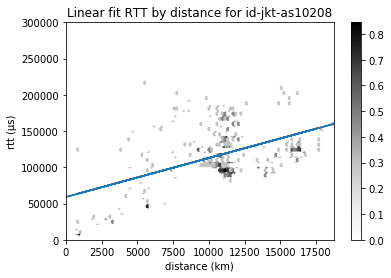

In [10]:
plot_linfit_rtt_by_dist(min_df.loc[609], figsize=(6,4), label=anchor_df.loc[609]['name'])

(7.0198730666899101, 0.48136017342846332)

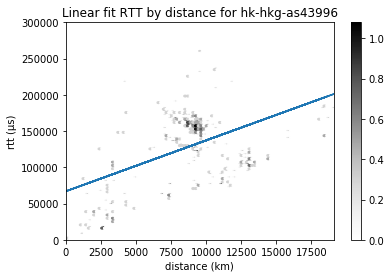

In [11]:
plot_linfit_rtt_by_dist(min_df.loc[423], figsize=(6,4), label=anchor_df.loc[423]['name'])

Now let's look at some better fits

(8.3256837137929285, 0.95614208953529467)

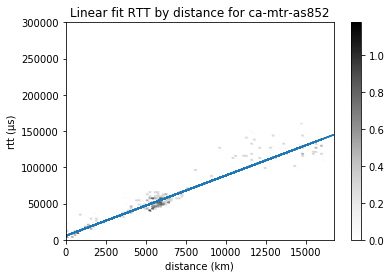

In [12]:
plot_linfit_rtt_by_dist(min_df.loc[644], figsize=(6,4), label=anchor_df.loc[644]['name'])

(8.8253476530410886, 0.94568955013745437)

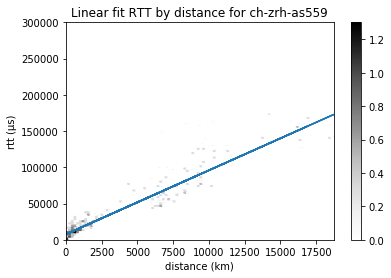

In [13]:
plot_linfit_rtt_by_dist(min_df.loc[15], figsize=(6,4), label=anchor_df.loc[15]['name'])

(8.7909300502776855, 0.95393054142606304)

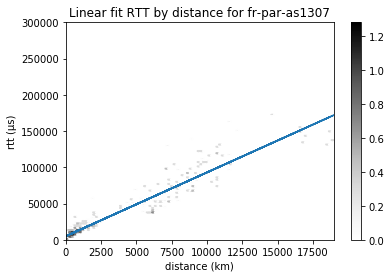

In [14]:
plot_linfit_rtt_by_dist(min_df.loc[978], figsize=(6,4), label=anchor_df.loc[978]['name'])

Thoroughly unsurprising. Better connected anchors are easier to geolocate.

Now let's look at a few time series of RTTs over paths, as an illustration of RTT dynamics

In [15]:
def plot_rtt_series(aid, pid): 

    example_ts_df = rtt_df[(rtt_df['aid'] == aid) & (rtt_df['pid'] == pid)].loc[:,['time','rtt','af']]

    example_ts_df_ip4 = example_ts_df[example_ts_df['af'] == 4]
    example_ts_df_ip6 = example_ts_df[example_ts_df['af'] == 6]
    plt.plot(example_ts_df_ip4['time'],example_ts_df_ip4['rtt'],".")

    plt.plot(example_ts_df_ip6['time'],example_ts_df_ip6['rtt'],".")

    plt.xlabel("time")
    plt.ylabel("RTT µs")
    plt.legend(labels=['ip4','ip6'])
    plt.title("RTT series for {} ({}) from probe {}".format(anchor_df.loc[aid]['name'], aid, pid))

def plot_random_rtt_series():
    random_aid = np.random.choice(min_df.index.levels[0].values)
    random_pid = np.random.choice(min_df.loc[random_aid].index.values)
    plot_rtt_series(random_aid, random_pid)

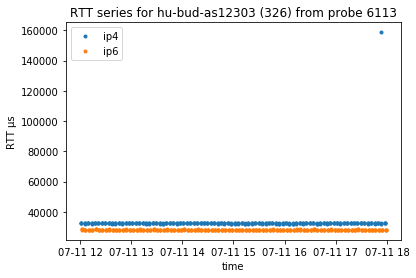

In [16]:
plot_random_rtt_series()

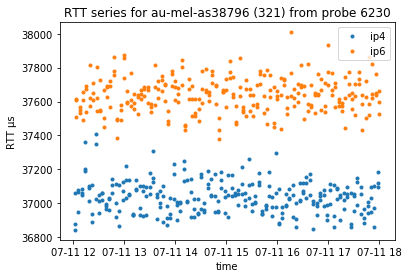

In [17]:
plot_random_rtt_series()

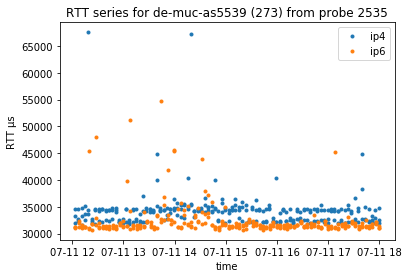

In [18]:
plot_random_rtt_series()

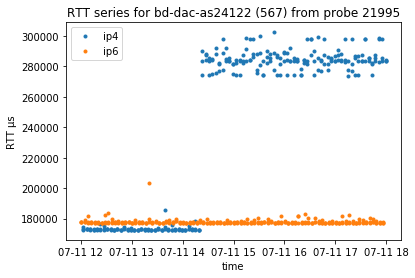

In [19]:
plot_rtt_series(567, 21995)

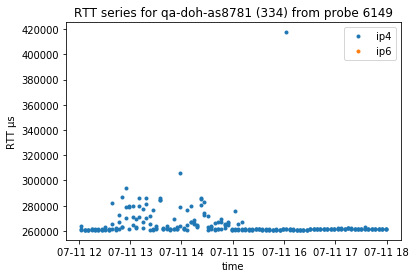

In [20]:
plot_random_rtt_series()

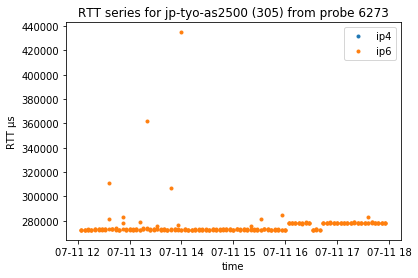

In [21]:
plot_random_rtt_series()

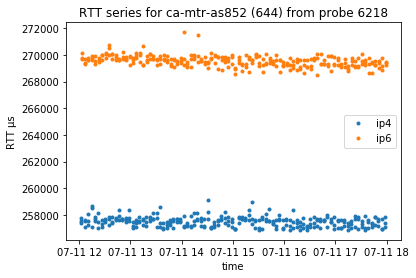

In [22]:
plot_random_rtt_series()

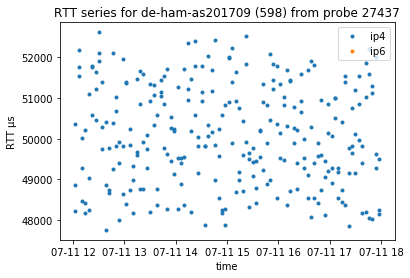

In [23]:
plot_random_rtt_series()

### Error estimation

For each distance sample, calculate a distance from a minimum RTT based on a linear model, then determine the absolute value of the distance and plot an ECDF.

In [24]:
c = 299792458
def dist_for_rtt(rtt):
    return (c / 1e9) * ilf * rtt / 2

min_df['excl_km'] = (c / 1e9) * ilf * (min_df['minrtt'] / 2)
min_df['lin_km'] = (c / 1e9) * slf * (min_df['minrtt'] / 2)
min_df['c_km'] = (c / 1e9) * (min_df['minrtt'] / 2)

In [25]:
def plot_ecdf(ser):
    ser = ser.sort_values()
    cdf = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cdf, index=ser)
    ser_cdf.plot(drawstyle='steps')
    plt

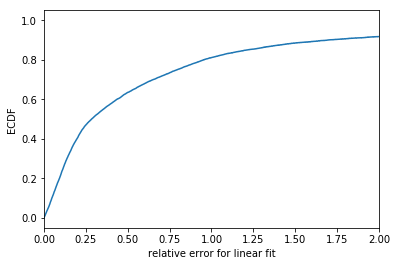

In [26]:
plot_ecdf(abs(min_df['lin_km'] - min_df['km']) / min_df['km'])
plt.xlim(0,2)
plt.xlabel("relative error for linear fit")
plt.ylabel("ECDF")

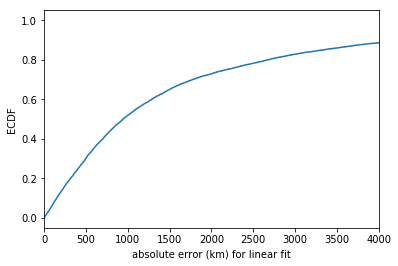

In [27]:
plot_ecdf(abs(min_df['lin_km'] - min_df['km']))
plt.xlim(0,4000)
plt.xlabel("absolute error (km) for linear fit")
plt.ylabel("ECDF")

### Cartographic illustration

Select a few anchors and all close-by probes, and plot the linear model circles on the map. Build a system for doing this randomly, so people who read the paper can choose their own examples.

In [28]:
from mpl_toolkits.basemap import Basemap

First, let's warm up: draw a global map of all our anchors and probes:

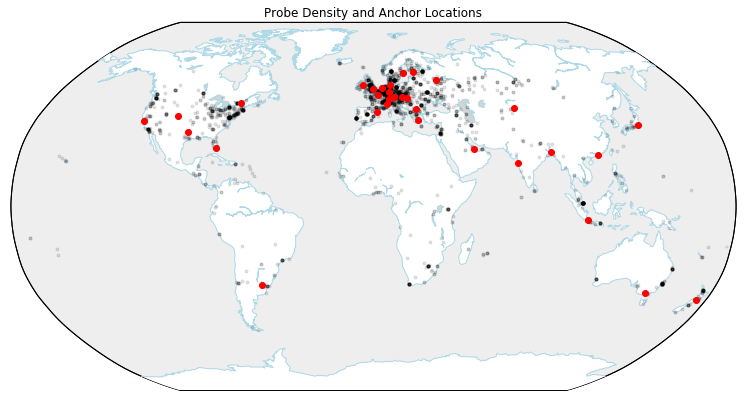

In [29]:
aloc_df = min_df.groupby(level=[0]).first().loc[:,['alon','alat']]
ploc_df = min_df.groupby(level=[1]).first().loc[:,['plon','plat']]

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
plt.figure(figsize=(13,10))
m = Basemap(projection='robin',lon_0=0,resolution='c')
m.drawcoastlines(color='lightblue')
m.fillcontinents(color='white',lake_color='lightgrey')
m.drawmapboundary(fill_color='#eeeeee')
plt.title("Probe Density and Anchor Locations")
for pid, point in ploc_df.iterrows():
    x, y = m(point['plon'], point['plat'])
    plt.plot(x,y,"k.",alpha=0.1)
for aid, point in aloc_df.iterrows():
    x, y = m(point['alon'], point['alat'])
    plt.plot(x,y,"ro")
plt.show()

Now we need some functions for drawing circles on projected maps:

In [30]:
def pointAtBearing(lon1, lat1, b, r):
    lon1 = lon1 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0 # convert to radians

    b = (b / 90) * math.pi / 2


    lat2 = math.asin(math.sin(lat1) * math.cos(r) + math.cos(lat1) * math.sin(r) * math.cos(b))
    lon2 = lon1 + math.atan2(math.sin(b) * math.sin(r) * math.cos(lat1), 
                             math.cos(r) - math.sin(lat1) * math.sin(lat2))
    
    lon2 = 180.0 * lon2 / math.pi
    lat2 = 180.0 * lat2 / math.pi

    return lon2, lat2

def circleWithRadius(lon, lat, km):
    """
    Return lat/lon coordinate vectors of a circle 
    with a given radius r (in units of Earth radius)
    """
    latArray = []
    lonArray = []
    
    for bearing in range(0,360):
        lon2, lat2 = pointAtBearing(lon, lat, bearing, km / 6371)
        latArray.append(lat2)
        lonArray.append(lon2)
        
    return lonArray, latArray

def plot_exclusion_circles_for(aid, amin_df=None, pids=None, mapscale=None, whichkm='excl_km'):
    # First, get a dataframe containing only the datapoints for the anchor and probes selected
    if amin_df is None:
        amin_df = min_df.loc[aid].loc[pids]
    
    # Now draw the basemap, scaled to fit most of the circles we'll draw
    if mapscale is None:
        mapscale = amin_df[whichkm].max() * 2000 + (max(km_range) * 500)
    alon = amin_df.iloc[0]['alon']
    alat = amin_df.iloc[0]['alat']
    plt.figure(figsize=(10,10))
    try:
        m = Basemap(width=mapscale,height=mapscale,
                    resolution='i',projection='laea',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    except ValueError:
        m = Basemap(resolution='c',projection='robin',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='#dddddd')
    m.drawmapboundary(fill_color='#dddddd')
    
    # Now plot circles
    for index, row in amin_df.iterrows():
        x, y = m(row['plon'],row['plat'])
        km = row[whichkm]
        if km > ( 6371 * math.pi ):
            continue
        clon, clat = circleWithRadius(row['plon'], row['plat'], km)
        X, Y = m(clon, clat)
        plt.plot(X, Y, 'b-', alpha=0.33)
    
    # And plot a dot for the anchor
    x, y = m(alon, alat)
    plt.plot(x, y, "ro")
    
    # And title
    plt.title("Exclusion circles for {} probes around {}".format(len(amin_df), anchor_df.loc[aid]['name']))
 

def plot_exclusion_circles_by_range(aid, km_range=(5,1000), max_rtt=None, max_probes=None, mapscale=None, whichkm = 'excl_km'):
    # First, get a dataframe containing only the datapoints for the anchor
    amin_df = min_df.loc[aid]
    
    # Drop probes that are outside the distance range
    amin_df = amin_df[amin_df['km'] < max(km_range)]
    amin_df = amin_df[amin_df['km'] > min(km_range)]
    
    # If distance range leads to too few probes, drop it
    if len(amin_df) < 3:
        amin_df = min_df.loc[aid]
    
    # Drop probes over max RTT
    if max_rtt is not None:
        amin_df = amin_df[amin_df['minrtt'] < max_rtt]
        # If max RTT leads to too few probes, drop it
        if len(amin_df) < 3:
            amin_df = min_df.loc[aid]

    if max_probes is not None and len(amin_df) > max_probes:
        amin_df = amin_df.sample(max_probes)

    plot_exclusion_circles_for(aid, amin_df=amin_df, mapscale=mapscale, whichkm=whichkm)


Now select an anchor and draw a local map centered on it, and draw circles centered on all probes within a reasonable distance.

In [31]:
aid_list = min_df.index.levels[0].sort_values().values
aix = 0

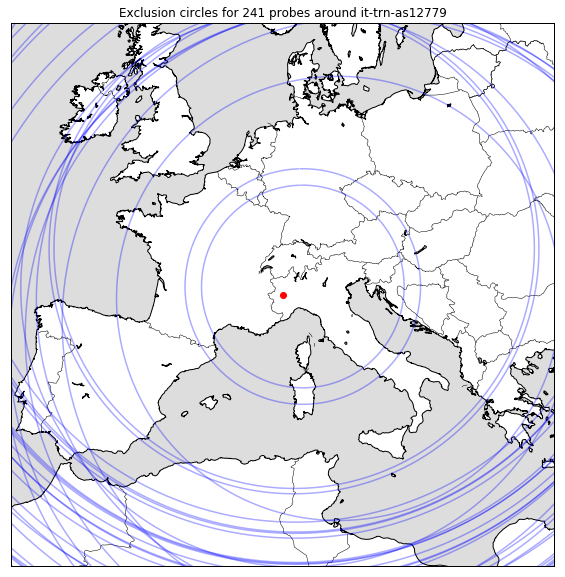

In [32]:
plot_exclusion_circles_by_range(aid_list[aix], 
                       km_range=(20,2000), max_rtt=40000, 
                       mapscale=3000000, whichkm="c_km")
aix += 1